In [1]:
from brian2 import *
%matplotlib inline
import numpy as np
from numpy import heaviside
from math import *
import pandas as pd
from numba import jit

@jit
# Potential function
def U(phi,I=1.01,gamma=1,T=4.615120516841259, tau=1):
    value = (I/gamma)*(1-np.exp(-gamma*T*phi/tau))
    return value
@jit
# Function to convert potential to 'phase' corresponding to Mirollo-Strogatz model
def U_inv(y,I=1.01,gamma=1,T=4.615120516841259,tau=1):
    value = (tau/(gamma*T))*np.log((1-(gamma*y/I))**(-1))
    return value
## Loading Inhibitory and Excitatory Edge topology from a 81 × 81 Matrix specifying 20 connections for each neuron 
# Import Sudoku matrices: (rows: pre-synaptic, columns: post-synaptic)

inhib_connect = np.loadtxt('Clueless_Sudoku_inhib.txt', dtype=int)
excit_connect = np.loadtxt('Clueless_Sudoku_excit.txt', dtype=int)

# Get tuples of corresponding connection indices for putting in Brian2's synapse connect() function
inhib_pre, inhib_post = inhib_connect.nonzero()
excit_pre, excit_post = excit_connect.nonzero()

In [14]:
start_scope()
N = 81                          # No. of neurons
tau = 10*ms                     # Time constant of neuron
A_osc = 0.2                     # Oscillation amplitude #?
freq = 25*Hz                    # Frequency of common oscillatory drive #?
transm_delay = pow(10,-5)*ms    # Delay between firing and reception of pulse by post-synaptic neuron

defaultclock.dt=0.1*ms

# Pulse strengths: inhibitory and excitatory
C_inh = -2.7*pow(10,-1)
C_exc = +2.8*pow(10,-6)

eqs = '''
dv/dt = (I+Ib-v)/tau : 1
phase = (freq*t) % 1.0 : 1
I = 0 : 1
Ib : 1
'''
# Create a neuron group 'G' following the above equation
G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', method='euler')
G.v = 'rand()' 
G.Ib=0


# Inhibitory synapses
S_inhib = Synapses(G,G, on_pre='v_post += C_inh', delay=transm_delay)
S_inhib.connect(i=inhib_pre, j=inhib_post)

# Excitatory synapses
S_excit = Synapses(G,G, on_pre='v_post += C_exc', delay=transm_delay)
S_excit.connect(i=excit_pre, j=excit_post)

# Record of potential for all neurons
potential = StateMonitor(G, 'v', record=True)
# Record of oscillatory drive (common to all neurons)
osc = StateMonitor(G, "I", record=0)
# Record of all spikes
firing_time = SpikeMonitor(G, 'phase')
t=10000
run(t*ms)
I = (str(list(G.I.__dict__.values())[1]))[86:88]


In [15]:
runnum=5

In [16]:
import os
script_dir = os.path.dirname('DC Only.ipynb')
results_dir = os.path.join(script_dir, 'NoInput_Results/')

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

plt.savefig(results_dir +str(runnum)+'intial')

<Figure size 432x288 with 0 Axes>

In [17]:
SMALL_SIZE = 10
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

csfont = {'fontname':'sans-serif'}
hfont = {'fontname':'serif'}
rcParams.update({'font.family':'serif'})
rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize

In [18]:

# def visualise_connectivity(S):
#     Ns = len(S.source)
#     Nt = len(S.target)
#     figure(figsize=(14, 7))
    
#     subplot(122)
#     plot(S.i, S.j, 'ok',mew=0.005,ms=5)
#     xlim(-1, Ns)
#     ylim(-1, Nt)
#     xlabel('Source neuron index',**hfont,fontsize=16)
#     ylabel('Target neuron index',**hfont,fontsize=16)
    

#     legend(['''Excitatory
# Synapses'''],bbox_to_anchor=(1, 1), loc="upper left")

# visualise_connectivity(S_excit)

# plt.savefig(results_dir +str(runnum)+'Excitatory_syn.png',bbox_inches="tight")

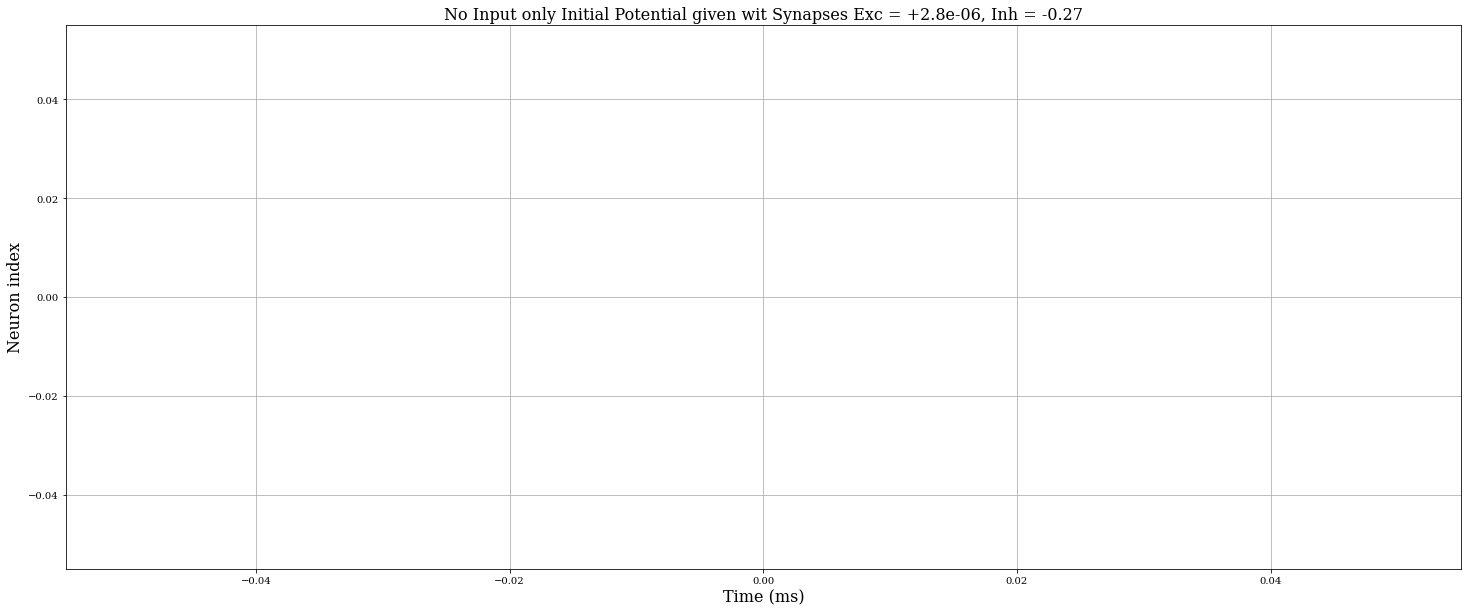

In [19]:
# Raster plot of firing
# Plot firing from 'index1' no. of iterations before end
figure(figsize=(25,10))
title('No Input only Initial Potential given wit Synapses Exc = +'+str(C_exc) + ', '+ 'Inh = ' + str(C_inh), fontsize=16)
grid()
xlabel('Time (ms)', fontsize=16)
ylabel('Neuron index', fontsize=16)
plot(firing_time.t/ms, firing_time.i,'|')
plt.savefig(results_dir +str(runnum)+ 'Full Raster plot.png')
show()

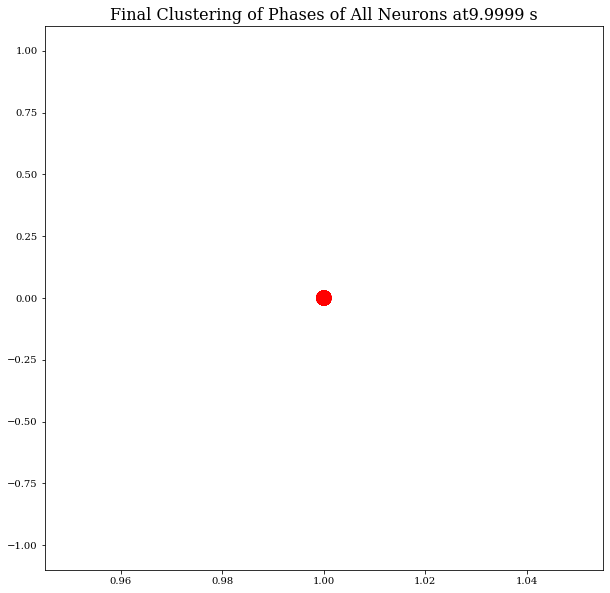

1


In [20]:
pot_arr = potential.v.copy()
pot_arr[pot_arr>1] = 1
phase = U_inv(pot_arr)
index2 = -1
sorted_phase = np.sort(phase[:,index2])

index3 = -1

sin_phase = np.sin(2*pi*phase[:,index3])
cos_phase = np.cos(2*pi*phase[:,index3])
colors=sin_phase
figure(figsize=(10,10))
scatter(cos_phase,sin_phase,c=colors, s=200, cmap='hsv', alpha=0.55)

# xlim((-1.1,1.1))
ylim((-1.1,1.1))
plt.title('Final Clustering of Phases of All Neurons at' + str(potential.t[index3]), fontsize=16)
savefig(results_dir +str(runnum)+ 'Final Clustering of Phases'+'.png',dpi=300)
show()
print(len(np.unique(sin_phase)))


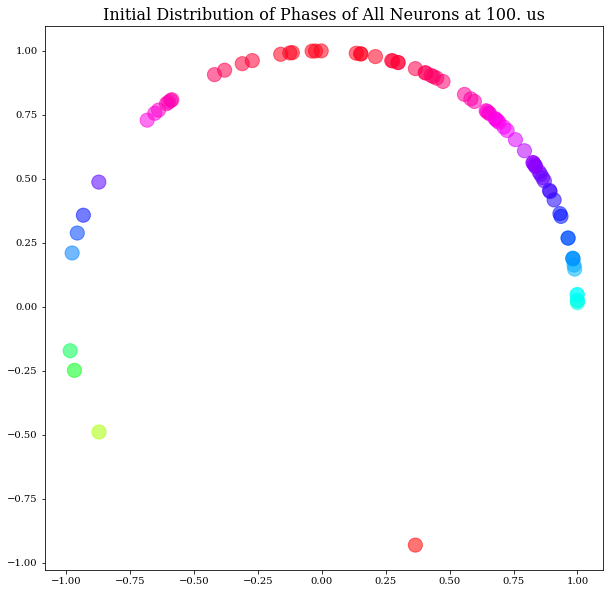

81


In [21]:
#Initial Distribution of Phases

index3 = 1
sin_phase = np.sin(2*pi*phase[:,index3])
cos_phase = np.cos(2*pi*phase[:,index3])
colors=sin_phase
figure(figsize=(10,10))
scatter(cos_phase,sin_phase,c=colors, s=200, cmap='hsv', alpha=0.55)

# xlim((-1.1,1.1))
#ylim((-1.1,1.1))
plt.title('Initial Distribution of Phases of All Neurons at ' + str(potential.t[index3]), fontsize=16)
plt.savefig(results_dir +str(runnum)+ 'Initial Distribution of Phases.png',dpi=120)
show()
print(len(np.unique(sin_phase)))

In [22]:
def get_time_float(st):
#     print(st,type(st))
    st = format(st)
#     print(st,type(st))
    spl = st.split()
    if spl[1] == 'ms':
        return float(spl[0])
    elif spl[1] == 's':
        return float(spl[0])*1000
    else:
        print('Conversion failed!')
        return False
    
msecond = 1e-3
second = 1

v_values = firing_time.values('t')
indice = []
firing_data = []
# print(v_values.keys())
for i in list(v_values.keys())[:]:
     firing_data += [[get_time_float(x),i] for x in v_values[i]]
#     n_index = i
#print(firing_data)

firing_data_short=np.asarray(firing_data) 
import json

with open(results_dir +'DC_only_firing_data_'+str(I)+'.json','w') as inf:
    json.dump(firing_data,inf)
    
firing_data_short=np.asarray(sorted(firing_data)) 
# firing_data_short=sorted(firing_data_short)
print(firing_data_short)

[]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

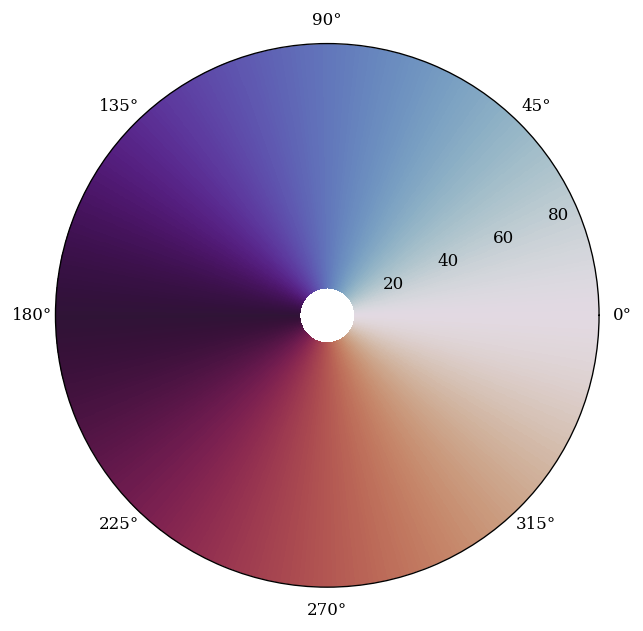

In [23]:
#At the end
low,up = 9590,9640
fir = np.asarray([x for x in firing_data_short if  x[0] > low and x[0] < up])

azimuths = np.arange(0, 361, 1)
zeniths = np.arange(9, 92, 1)
values = azimuths * np.ones((83, 361))
fig, ax = plt.subplots(dpi=120,subplot_kw=dict(projection='polar'), figsize=(6,6))
ax.pcolormesh(azimuths*np.pi/180.0, zeniths, values[:-1,:-1], cmap=plt.get_cmap('twilight'))
norm_phase = ((fir[:,0])*2*np.pi)
norm_indices = (fir[:,1])+10


theta = np.arange(0,2*np.pi,0.01)
for i in range(10,91,9):
    ax.plot(theta , i*np.ones_like(theta), ls='-', lw=0.2, color='gray')
    
    

ax.plot(norm_phase, norm_indices, color='#FFFF00', marker='.',mew=2, markersize=3, ls='')
ax.set_xticks([])
# ax.set_yticks(range(10,91,10))
# ax.set_axis_on()
plt.savefig(results_dir +str(runnum)+ 'Final Firing Phase Code.png',dpi=120)
# plt.savefig(results_dir +str(runnum)+ 'Initial Firing Phase Code.png')
plt.show()
from matplotlib import cm

# Plot linear raster plot with colour coding at the bottom
raster = plt.figure(figsize=(12,5))
gs = raster.add_gridspec(4,1)
fire = raster.add_subplot(gs[:3])
fire.plot(fir[:,0], fir[:,1], '|k',mew=3,ms=7)
fire.grid(True, 'both','y',linewidth=0.7)
for i in range(80):
    fire.axhline(y=i, linewidth=0.2, color='gray')
fire.set_yticks(np.arange(0,81,10))
xlabel('Time (ms)', fontsize=16)
ylabel('Neuron index', fontsize=16)
plt.savefig(results_dir +str(runnum)+ 'Rastor_Colored_Final.png')
plt.show()

In [ ]:
#In the Middle 
low,up = 500,550
k=(low,up)
fir = np.asarray([x for x in firing_data_short if  x[0] > low and x[0] < up])
azimuths = np.arange(0, 361, 1)
zeniths = np.arange(9, 92, 1)
values = azimuths * np.ones((83, 361))
fig, ax = plt.subplots(dpi=120,subplot_kw=dict(projection='polar'), figsize=(6,6))
ax.pcolormesh(azimuths*np.pi/180.0, zeniths, values[:-1,:-1], cmap=plt.get_cmap('twilight'))
norm_phase = ((fir[:,0])*2*np.pi)
norm_indices = (fir[:,1])+10

theta = np.arange(0,2*np.pi,0.01)
for i in range(10,91,9):
    ax.plot(theta , i*np.ones_like(theta), ls='-', lw=0.2, color='gray')
    
    

ax.plot(norm_phase, norm_indices, color='#FFFF00', marker='.',mew=2, markersize=3, ls='')
ax.set_xticks([])
# plt.savefig(results_dir +str(runnum)+ 'Final Firing Phase Code.png',dpi=120)
plt.savefig(results_dir +str(runnum)+ 'Mid Firing Phase Code.png',dpi=120)
plt.show()

# Plot linear raster plot with colour coding at the bottom
raster = plt.figure(figsize=(12,5))
gs = raster.add_gridspec(4,1)
xlim = k

fire = raster.add_subplot(gs[:3])
fire.plot(fir[:,0], fir[:,1], '|k',mew=3,ms=7)
fire.grid(True, 'both','y',linewidth=0.7)
for i in range(80):
    fire.axhline(y=i, linewidth=0.2, color='gray')
fire.set_yticks(np.arange(0,81,10))
xlabel('Time (ms)', fontsize=16)
ylabel('Neuron index', fontsize=16)
plt.savefig(results_dir +str(runnum)+ 'Rastor_Colored_Mid.png',dpi=120)
plt.show()

In [ ]:
#Initial 
low,up = 0,50
k=(low,up)
fir = np.asarray([x for x in firing_data_short if  x[0] > low and x[0] < up])
azimuths = np.arange(0, 361, 1)
zeniths = np.arange(9, 92, 1)
values = azimuths * np.ones((83, 361))
fig, ax = plt.subplots(dpi=120,subplot_kw=dict(projection='polar'), figsize=(6,6))
ax.pcolormesh(azimuths*np.pi/180.0, zeniths, values[:-1,:-1], cmap=plt.get_cmap('twilight'))
norm_phase = ((fir[:,0])*2*np.pi)
norm_indices = (fir[:,1])+10

theta = np.arange(0,2*np.pi,0.01)
for i in range(10,91,9):
    ax.plot(theta , i*np.ones_like(theta), ls='-', lw=0.2, color='gray')
    
    

ax.plot(norm_phase, norm_indices, color='#FFFF00', marker='.',mew=2, markersize=3, ls='')
ax.set_xticks([])
# plt.savefig(results_dir +str(runnum)+ 'Final Firing Phase Code.png',dpi=120)
plt.savefig(results_dir +str(runnum)+ 'Mid Firing Phase Code.png',dpi=120)
plt.show()

# Plot linear raster plot with colour coding at the bottom
raster = plt.figure(figsize=(12,5))
gs = raster.add_gridspec(4,1)
xlim = k

fire = raster.add_subplot(gs[:3])
fire.plot(fir[:,0], fir[:,1], '|k',mew=3,ms=7)
fire.grid(True, 'both','y',linewidth=0.7)
for i in range(80):
    fire.axhline(y=i, linewidth=0.2, color='gray')

fire.set_yticks(np.arange(0,81,10))
xlabel('Time (ms)', fontsize=16)
ylabel('Neuron index', fontsize=16)
plt.savefig(results_dir +str(runnum)+ 'Rastor_Colored_Mid.png',dpi=120)
plt.show()